In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from scipy.stats import friedmanchisquare, wilcoxon
from statsmodels.stats.multitest import multipletests
import pingouin as pg

from src.extract_experimental_results import get_metric_matrices

# Load Experiment Results

In [2]:
# Load metric values from experimental results
mats = get_metric_matrices("./output")  

# Accuracy
acc_baseline = mats['BaselineCNN']['accuracy'].ravel()
acc_deeper = mats['DeeperCNN']['accuracy'].ravel()
acc_regularized = mats['RegularizedCNN']['accuracy'].ravel()
acc = [acc_baseline, acc_deeper, acc_regularized]

# F1-Score (macro)
f1_baseline = mats['BaselineCNN']['f1'].ravel()
f1_deeper = mats['DeeperCNN']['f1'].ravel()
f1_regularized = mats['RegularizedCNN']['f1'].ravel()
f1 = [f1_baseline, f1_deeper, f1_regularized]

# Training Time (minutes)
traintime_baseline = mats['BaselineCNN']['duration'].ravel()
traintime_deeper = mats['DeeperCNN']['duration'].ravel()
traintime_regularized = mats['RegularizedCNN']['duration'].ravel()
traintime = [traintime_baseline, traintime_deeper, traintime_regularized]

# Seeds
seeds = mats['BaselineCNN']['seeds'] if mats['BaselineCNN']['seeds'] == mats['DeeperCNN']['seeds'] == mats['RegularizedCNN']['seeds'] else None  
assert seeds is not None, "Seeds do not match across models."

# print(f"Vector 1:\n{acc_baseline}\n")
# print(f"Vector 2:\n{acc_deeper}\n")
# print(f"Vector 3:\n{acc_regularized}\n")

models = ['BaselineCNN', 'DeeperCNN', 'RegularizedCNN']
metrics = ['Accuracy', 'F1-Score (macro)', 'Training Time (minutes)']

### Plot experimental results

Mean Accuracy:
0.4214206896551724 0.46015632183908045 0.4014574712643678
Std dev (acc)[base,deep,reg]: (0.007340347598510387, 0.02900957933094031, 0.031889088409233934)
25
Mean F1-Score (macro):
0.40360291548521643 0.44220595326306844 0.3820235707868212
Std dev (f1)[base,deep,reg]: (0.007324226790229058, 0.030925828376775277, 0.03297015990479736)
Mean Time:
11.088584363619486 14.614976420720417 14.43541854842504
Std dev (time)[base,deep,reg]: (0.4806252030401643, 0.48482616006322393, 0.4015241905381133)
25


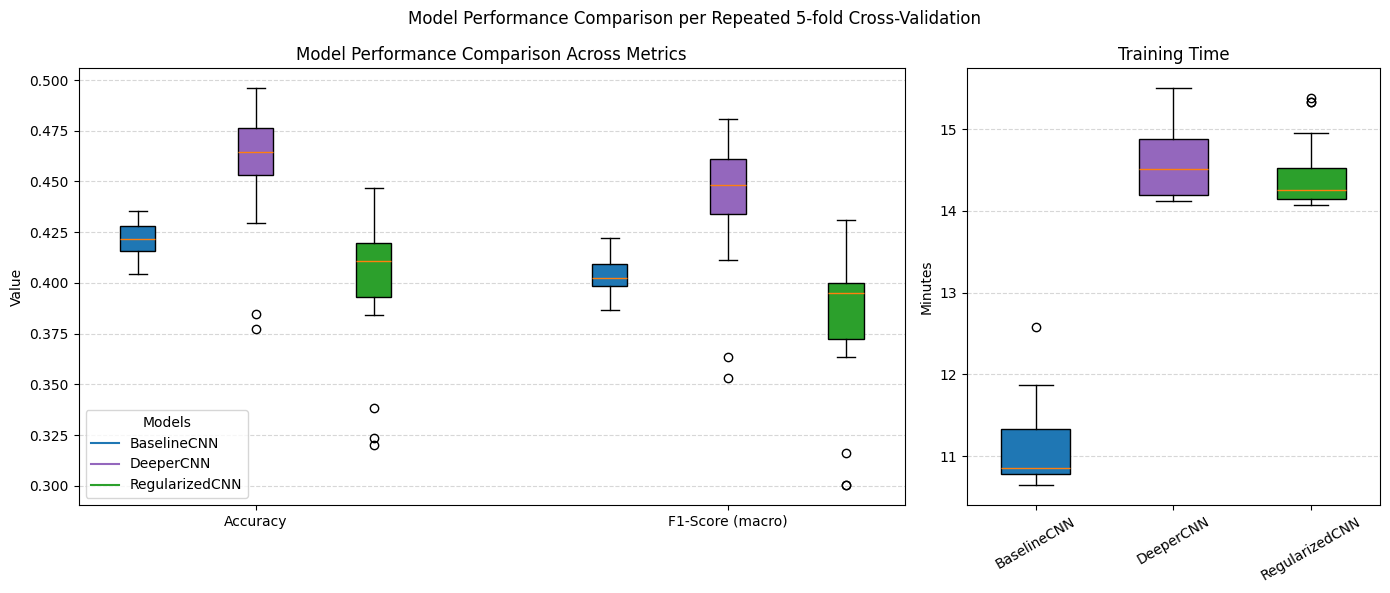

In [14]:
# Plot means
print('Mean Accuracy:')
print(acc_baseline.mean(), acc_deeper.mean(), acc_regularized.mean())
print(f'Std dev (acc)[base,deep,reg]: {np.std(acc_baseline), np.std(acc_deeper), np.std(acc_regularized)}')
print(len(acc_baseline))
print('Mean F1-Score (macro):')
print(f1_baseline.mean(), f1_deeper.mean(), f1_regularized.mean())
print(f'Std dev (f1)[base,deep,reg]: {np.std(f1_baseline), np.std(f1_deeper), np.std(f1_regularized)}')
print('Mean Time:')
print(traintime_baseline.mean(), traintime_deeper.mean(), traintime_regularized.mean())
print(f'Std dev (time)[base,deep,reg]: {np.std(traintime_baseline), np.std(traintime_deeper), np.std(traintime_regularized)}')
print(len(traintime_baseline))
# Combine data in metric order
data = acc + f1

metrics = ['Accuracy', 'F1-Score (macro)']
n_models = len(models)
n_metrics = len(metrics)

gap = 1          # space between metric groups
box_width = 0.3

positions = []
for i in range(n_metrics):
    start = i * (n_models + gap)
    for j in range(n_models):
        positions.append(start + j)

fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(14, 6),
    gridspec_kw={"width_ratios": [2, 1]}  # performance plot wider
)

# Performance Boxplot
bp = ax1.boxplot(
    data,
    positions=positions,
    widths=box_width,
    patch_artist=True,
    showfliers=True
)

colors = ['tab:blue', 'tab:purple', 'tab:green']

for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i % n_models])

xticks = [
    np.mean(positions[i*n_models:(i+1)*n_models])
    for i in range(n_metrics)
]

ax1.set_xticks(xticks)
ax1.set_xticklabels(metrics)

ax1.set_ylabel("Value")
ax1.set_title("Model Performance Comparison Across Metrics")

# Legend
for i, model in enumerate(models):
    ax1.plot([], [], color=colors[i], label=model)

ax1.legend(title="Models")
ax1.grid(axis="y", linestyle="--", alpha=0.5)


# Training Time Boxplot
bp_time = ax2.boxplot(
    traintime,
    widths=0.5,
    patch_artist=True,
    showfliers=True
)

for i, box in enumerate(bp_time['boxes']):
    box.set_facecolor(colors[i])

ax2.set_xticks(range(1, n_models + 1))
ax2.set_xticklabels(models, rotation=30)
ax2.set_ylabel("Minutes")
ax2.set_title("Training Time")

ax2.grid(axis="y", linestyle="--", alpha=0.5)

plt.suptitle("Model Performance Comparison per Repeated 5-fold Cross-Validation")

plt.tight_layout()
plt.savefig("test_visualization/model_performance_comparison.png", dpi=300)
plt.show()



# Statistical Analysis

In [4]:
# Prepare to store test results
fried_diffs = []
wilc_diffs = []

p_scipy_all = []
p_pingouin_all = []

## Statistical Analysis with `scipy`

### Friedman ANOVA Test

In [5]:
# Accuracy - Friedman test
stat_fried_acc, p_fried_acc = friedmanchisquare(acc_baseline, acc_deeper, acc_regularized)
print(f"(Scipy) Friedman test statistic: \n{stat_fried_acc}, \np-value: {p_fried_acc}")
if p_fried_acc < 0.05:
    print(f"Significant differences found for 'acc' by Friedman test. Proceed with Wilcoxon signed-rank tests.\n")

# F1-Score - Friedman test
stat_fried_f1, p_fried_f1 = friedmanchisquare(f1_baseline, f1_deeper, f1_regularized)
print(f"(Scipy) Friedman test statistic: \n{stat_fried_f1}, \np-value: {p_fried_f1}")
if p_fried_f1 < 0.05:
    print(f"Significant differences found for 'f1' by Friedman test. Proceed with Wilcoxon signed-rank tests.\n")


(Scipy) Friedman test statistic: 
32.95999999999998, 
p-value: 6.963489711028059e-08
Significant differences found for 'acc' by Friedman test. Proceed with Wilcoxon signed-rank tests.

(Scipy) Friedman test statistic: 
31.920000000000016, 
p-value: 1.1712782232342687e-07
Significant differences found for 'f1' by Friedman test. Proceed with Wilcoxon signed-rank tests.



### Wilcoxon paired test

In [6]:
# Acc Wilcoxon tests
stat_will12, p_wil12 = wilcoxon(acc_baseline, acc_deeper)
stat_will13, p_wil13 = wilcoxon(acc_baseline, acc_regularized)
stat_will23, p_wil23 = wilcoxon(acc_deeper, acc_regularized)
p_wilcoxon_scipy = [p_wil12, p_wil13, p_wil23]
print(f"(Scipy) Acc Wilcoxon test statistic [1-2, 1-3, 2-3]: {[stat_will12, stat_will13, stat_will23]}")
print(f"(Scipy) Acc Wilcoxon p-value [1-2, 1-3, 2-3]: \n{p_wilcoxon_scipy}")

# F1-score Wilcoxon tests
f1_stat_will12, f1_p_wil12 = wilcoxon(f1_baseline, f1_deeper)
f1_stat_will13, f1_p_wil13 = wilcoxon(f1_baseline, f1_regularized)
f1_stat_will23, f1_p_wil23 = wilcoxon(f1_deeper, f1_regularized)
f1_p_wilcoxon_scipy = [f1_p_wil12, f1_p_wil13, f1_p_wil23]
print('\n')
print(f"(Scipy) F1-score Wilcoxon test statistic [1-2, 1-3, 2-3]: {[f1_stat_will12, f1_stat_will13, f1_stat_will23]}")
print(f"(Scipy) F1-score Wilcoxon p-value [1-2, 1-3, 2-3]: \n{f1_p_wilcoxon_scipy}")

(Scipy) Acc Wilcoxon test statistic [1-2, 1-3, 2-3]: [22.0, 58.0, 1.0]
(Scipy) Acc Wilcoxon p-value [1-2, 1-3, 2-3]: 
[3.1948089599609375e-05, 0.0037809014320373535, 1.1920928955078125e-07]


(Scipy) F1-score Wilcoxon test statistic [1-2, 1-3, 2-3]: [24.0, 50.0, 1.0]
(Scipy) F1-score Wilcoxon p-value [1-2, 1-3, 2-3]: 
[4.5418739318847656e-05, 0.001625359058380127, 1.1920928955078125e-07]


### Hommel post hoc

In [7]:
# Acc
post_p = multipletests(
    [p_wil12, p_wil13, p_wil23], 
    alpha=0.05, 
    method='hommel', 
    maxiter=1, 
    is_sorted=False, 
    returnsorted=False
)

print(f"(statsmodels) Acc Post-hoc Hommel corrected p-values (from scipy): \n{post_p}\n")

# F1-score
f1_post_p = multipletests(
    f1_p_wilcoxon_scipy, 
    alpha=0.05, 
    method='hommel', 
    maxiter=1, 
    is_sorted=False, 
    returnsorted=False
)

print(f"(statsmodels) F1-score Post-hoc Hommel corrected p-values (from scipy): \n{f1_post_p}\n")

(statsmodels) Acc Post-hoc Hommel corrected p-values (from scipy): 
(array([ True,  True,  True]), array([6.38961792e-05, 3.78090143e-03, 3.57627869e-07]), 0.016952427508441503, 0.016666666666666666)

(statsmodels) F1-score Post-hoc Hommel corrected p-values (from scipy): 
(array([ True,  True,  True]), array([9.08374786e-05, 1.62535906e-03, 3.57627869e-07]), 0.016952427508441503, 0.016666666666666666)



## Power Analysis

### Effect size: Friedman ANOVA

In [8]:
# Effect size for Friedman ANOVA
chi2_acc = stat_fried_acc
n = len(acc_baseline)
k = len(models)

kendalls_w_acc = chi2_acc / (n * (k - 1))

print(f"Kendall's W (eta^2) for acc: {kendalls_w_acc:.4f}")

chi2_f1 = stat_fried_f1
kendalls_w_f1 = chi2_f1 / (n * (k - 1))

print(f"Kendall's W (eta^2) for f1: {kendalls_w_f1:.4f}")

Kendall's W (eta^2) for acc: 0.6592
Kendall's W (eta^2) for f1: 0.6384


### Effect size: Wilcoxon

In [9]:
# Effect size for Wilcoxon
def wilcoxon_effect_size(x, y, stat, p):
    # Number of non-zero differences
    diff = np.array(x) - np.array(y)
    n = np.sum(diff != 0)

    # Expected value and standard deviation of W
    mean_w = n * (n + 1) / 4
    sd_w = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)

    # Z-score
    z = (stat - mean_w) / sd_w

    # Effect size r
    r = abs(z) / np.sqrt(n)

    return r

# Acc
r12 = wilcoxon_effect_size(acc_baseline, acc_deeper, stat_will12, p_wil12)
r13 = wilcoxon_effect_size(acc_baseline, acc_regularized, stat_will13, p_wil13)
r23 = wilcoxon_effect_size(acc_deeper, acc_regularized, stat_will23, p_wil23)

print('Effect size r12:', r12)
print('Effect size r13:', r13)
print('Effect size r23:', r23)


# F1-score
f1_r12 = wilcoxon_effect_size(f1_baseline, f1_deeper, f1_stat_will12, f1_p_wil12)
f1_r13 = wilcoxon_effect_size(f1_baseline, f1_regularized, f1_stat_will13, f1_p_wil13)
f1_r23 = wilcoxon_effect_size(f1_deeper, f1_regularized, f1_stat_will23, f1_p_wil23)
print('\n')
print('Effect size f1_r12:', f1_r12)
print('Effect size f1_r13:', f1_r13)
print('Effect size f1_r23:', f1_r23)


Effect size r12: 0.7560842204518552
Effect size r13: 0.5623544557809173
Effect size r23: 0.8690932498432357


Effect size f1_r12: 0.7453214557479143
Effect size f1_r13: 0.6054055145966812
Effect size f1_r23: 0.8690932498432357


## Statistical Analysis with `pingouin`

In [10]:

df = pd.DataFrame({
    'acc_baseline': {i: v for i, v in enumerate(acc_baseline)},
    'acc_deeper': {i: v for i, v in enumerate(acc_deeper)},
    'acc_regularized': {i: v for i, v in enumerate(acc_regularized)},
})

# Friedman test
p_fried_ping = pg.friedman(data=df, method='chisq')
print(f"(pingouin) Friedman test p-value: {p_fried_ping['p-unc'].values[0]}")

# Wilcoxon paired test
p_wil12_ping = pg.wilcoxon(acc_baseline, acc_deeper)['p-val'].values[0]
p_wil13_ping = pg.wilcoxon(acc_baseline, acc_regularized)['p-val'].values[0]
p_wil23_ping = pg.wilcoxon(acc_deeper, acc_regularized)['p-val'].values[0]
p_wilcoxon_ping = [p_wil12_ping, p_wil13_ping, p_wil23_ping]
print(f"(pingouin) Wilcoxon p-value [1-2, 1-3, 2-3]: {p_wilcoxon_ping}")

# Hommel post hoc
post_p = multipletests(
    [p_wil12, p_wil13, p_wil23], 
    alpha=0.05, 
    method='hommel', 
    maxiter=1, 
    is_sorted=False, 
    returnsorted=False
)

print(f"(statsmodels) Post-hoc Hommel corrected p-values (from pingouin): {post_p[1]}")


(pingouin) Friedman test p-value: 6.96348971102798e-08
(pingouin) Wilcoxon p-value [1-2, 1-3, 2-3]: [3.1948089599609375e-05, 0.0037809014320373535, 1.1920928955078125e-07]
(statsmodels) Post-hoc Hommel corrected p-values (from pingouin): [6.38961792e-05 3.78090143e-03 3.57627869e-07]


In [11]:
# === Power analysis ===
# print("\nPower Analysis:")
# # Effect size calculation
# ef12 = pg.compute_effsize(acc_baseline, acc_deeper, paired=True, eftype='eta-square')
# ef13 = pg.compute_effsize(acc_baseline, acc_regularized, paired=True, eftype='eta-square')
# ef23 = pg.compute_effsize(acc_deeper, acc_regularized, paired=True, eftype='eta-square')
# print(f"(pingouin) Effect size (eta-square) between acc_baseline and acc_deeper: {ef12}")
# print(f"(pingouin) Effect size (eta-square) between acc_baseline and acc_regularized: {ef13}")
# print(f"(pingouin) Effect size (eta-square) between acc_deeper and acc_regularized: {ef23}")



# Visualization of p-values

### Plot comparison of `scipy` and `pingouin`

In [12]:
comparisons = ["BaselineCNN vs DeeperCNN", "DeeperCNN vs RegularizedCNN", "BaselineCNN vs RegularizedCNN"]

p_scipy = p_fried_acc
p_pingouin = p_fried_ping['p-unc'].values[0]

fried_diff = np.abs(p_scipy - p_pingouin)
print(fried_diff)

wilc_diff = np.abs(np.array(p_wilcoxon_scipy) - np.array(p_wilcoxon_ping))
print(wilc_diff)

# x = np.arange(len(comparisons))
# width = 0.3                     # width of the bars

# fig, ax = plt.subplots(figsize=(8, 5))

# rects1 = ax.bar(x - width/2, p_scipy, width, label='SciPy')
# rects2 = ax.bar(x + width/2, p_pingouin, width, label='Pingouin')

# ax.text(0.5, 0.65, f'p-value difference: {diff:.4f}', fontsize=10, color='black')

# # Labels and formatting
# ax.set_ylabel('p-value')
# ax.set_title('Comparison of Friedman-ANOVA p-values: SciPy vs. Pingouin')
# ax.set_xticks(x)
# ax.set_xticklabels(comparisons)
# ax.axhline(0.05, color='red', linestyle='--', linewidth=1, label='α = 0.05')
# plt.ylim(0.3, 0.75) 
# ax.legend()

# plt.tight_layout()
# plt.show()
fried_diffs.append(fried_diff)
wilc_diffs.append(wilc_diff)

p_scipy_all.append(p_scipy)
p_pingouin_all.append(p_pingouin)



7.940933880509066e-22
[0. 0. 0.]


### Plot Friedman ANOVA


Summary of p-value differences across seeds:
Friedman-ANOVA p-value differences: [7.940933880509066e-22]
Wilcoxon p-value differences: [array([0., 0., 0.])]


ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

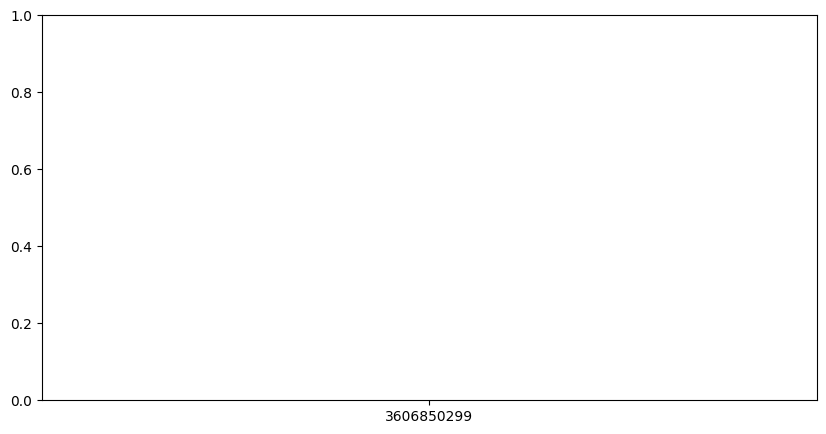

In [13]:
print("\nSummary of p-value differences across seeds:")
print(f"Friedman-ANOVA p-value differences: {fried_diffs}")
print(f"Wilcoxon p-value differences: {wilc_diffs}")

plt.figure(figsize=(10, 5))

assert mats['BaselineCNN']['seeds'] == mats['DeeperCNN']['seeds'] == mats['RegularizedCNN']['seeds'], "Seed list do not match across model variants."
seeds = mats['BaselineCNN']['seeds']
plt.plot(seeds, fried_diffs, marker="o", linestyle="-")

plt.text(
0.95, 0.95, 
f'Mean p-value difference: {np.mean(fried_diffs):.4f}', 
horizontalalignment='right', 
verticalalignment='top'
)

# Set custom tick labels (your seed IDs)
plt.xticks(seeds)
plt.legend()
plt.ylabel('Absolute p-value Difference')
plt.title('Friedman-ANOVA p-value Differences between SciPy and Pingouin')
plt.grid()
plt.tight_layout()
plt.savefig('friedman_pvalue_differences.png', dpi=200)
plt.close()

#### Plot Friedman ANOVA as Bar plots

In [ ]:


x = np.arange(len(seeds))
width = 0.2

fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - width/2, p_scipy_all, width, label='SciPy', color='#ADD8E6')
rects2 = ax.bar(x + width/2, p_pingouin_all, width, label='Pingouin', color='#D8BFD8')

def add_labels(rects, top: float = 0.0):
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width()/2,
            (height/2)+top,                      # middle of bar; use height*0.9 for top
            f"{height:.3f}",              # value with 3 decimals
            ha='center', va='center',
            fontsize=8, color='black'
        )

add_labels(rects1, 0.05)
add_labels(rects2, -0.05)

# Labels and formatting
ax.set_ylabel('p-value')
ax.set_title('Comparison of Friedman-ANOVA p-values: SciPy vs. Pingouin')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()

plt.tight_layout()
plt.savefig('bar_friedman_pvalue_differences.png', dpi=200)